In [197]:
import pandas as pd

This annex includes global historical and projected data by scenario for the following four datasets : energy supply, total final consumption, electricity sector: gross electricity generation and electrical capacity, CO₂ emissions: carbon dioxide (CO2) emissions from fossil fuel combustion and industrial processes.

The xlsx file contains 33 sheets. We split first the world indicators, which contain two tables in each sheet.




In [ ]:
# Load the Excel file
excel_file = pd.ExcelFile('WEO2023_Free_Dataset.xlsx')

# Define the range of sheet indices you want to process
start_sheet_index = 9  # Index starts from 0, so 9 corresponds to the 10th sheet
end_sheet_index = 33   # Index corresponding to the 34th sheet

# Iterate over each sheet in the specified range
for sheet_index in range(start_sheet_index, end_sheet_index + 1):
    sheet_name = excel_file.sheet_names[sheet_index]  # Get sheet name using index

    # Read the sheet into a DataFrame
    sheet_df = pd.read_excel(excel_file, sheet_name=sheet_name)

    # Initialize variables for detecting tables
    table_start = None
    in_table = False

    # Iterate over each row in the DataFrame
    for i, row in sheet_df.iterrows():
        # Check if the row contains any non-null values
        if not row.isnull().all():
            # If not in a table, mark the start of the table
            if not in_table:
                table_start = i
                in_table = True
        else:
            # If in a table, mark the end of the table and save it
            if in_table:
                # Extract the table
                table_df = sheet_df.iloc[table_start:i]
                # Save the table as a CSV file
                csv_filename = f"{sheet_name}_table.csv"
                table_df.to_csv(csv_filename, index=False)
                #print(f"Saved table from '{sheet_name}' as {csv_filename}")
                in_table = False

    # If still in a table at the end of the sheet, process it
    if in_table:
        # Extract the table
        table_df = sheet_df.iloc[table_start:]
        # Save the table as a CSV file
        csv_filename = f"{sheet_name}_table.csv"
        table_df.to_csv(csv_filename, index=False)
        #print(f"Saved table from '{sheet_name}' as {csv_filename}")


First, we treat the coal data (demand, generation and production)

In [ ]:
df1 = pd.read_csv('Coal demand (Mtce)_table.csv')
df2 = pd.read_csv('Coal generation (TWh)_table.csv')
df3 =pd.read_csv('Coal production (Mtce)_table.csv')

In [ ]:
import pandas as pd

def clean_and_rename(df):
    # Calculate the total number of missing values in each column
    missing_values = df.isnull().sum()

    # Calculate the total number of values in each column
    total_values = df.shape[0]

    # Calculate the percentage of missing values in each column
    percentage_missing = (missing_values / total_values) * 100

    # Create a DataFrame to display the percentage of missing values
    missing_data = pd.DataFrame({'Column': df.columns, 'Percentage Missing': percentage_missing})

    # Drop columns with over 50% missing values
    columns_to_drop = missing_data[missing_data['Percentage Missing'] > 50]['Column']
    df_cleaned = df.drop(columns_to_drop, axis=1)
    df_cleaned = df_cleaned.drop(columns=['Unnamed: 9', 'Year', 'Scenario', 'Publication'])
    df_cleaned = df_cleaned.fillna(0)
    df_cleaned = df_cleaned.rename(columns={
        'Stated Policies Scenario': 'Hist Year 2010',
        'Stated Policies Scenario.1': 'Hist Year 2021',
        'Stated Policies Scenario.2': 'Hist Year 2022',
        'Stated Policies Scenario.3': 'Stat Year 2030',
        'Stated Policies Scenario.4': 'Stat Year 2050',
        'Announced Pledges Scenario': 'Ann Year 2030',
        'Announced Pledges Scenario.1': 'Ann Year 2050'
    })

    return df_cleaned, missing_data

# Example usage with three datasets
df1_cleaned, missing_data1 = clean_and_rename(df1)
df2_cleaned, missing_data2 = clean_and_rename(df2)
df3_cleaned, missing_data3 = clean_and_rename(df3)


Now, Let us define the category Region as a quantitative/numerical variable using clustering method!

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
def perform_clustering(df):
    # Create a mapping dictionary for grouping regions
    region_group_mapping = {
        'North America': 'North America',
        'Central and South America': 'Central and South America',
        'United States': 'North America',
        'Brazil': 'Central and South America',
        'Europe': 'Europe',
        'European Union': 'Europe',
        'Russia': 'Eurasia',
        'Middle East': 'Middle East',
        'China': 'Asia Pacific',
        'India': 'Asia Pacific',
        'Japan': 'Asia Pacific',
        'Southeast Asia': 'Asia Pacific',
        'Africa': 'Africa'  # Include 'Africa' in the grouping dictionary
    }

    # Map regions to the grouped regions
    df['Region_Grouped'] = df['Region'].map(region_group_mapping)

    # Drop rows with NaN values in 'Region_Grouped' column
    df.dropna(subset=['Region_Grouped'], inplace=True)

    # Initialize LabelEncoder
    label_encoder = LabelEncoder()

    # Encode the 'Region_Grouped' column
    df['Region_Encoded'] = label_encoder.fit_transform(df['Region_Grouped'])

    # Perform clustering on encoded regions
    kmeans = KMeans(n_clusters=7, random_state=0)  # Adjust number of clusters as needed
    kmeans.fit(df[['Region_Encoded']])

    # Add cluster labels to DataFrame
    df['Cluster_Labels'] = kmeans.labels_
    df.drop(columns= ['Region_Encoded'])

    return df

df1_clustered = perform_clustering(df1_cleaned)
df2_clustered = perform_clustering(df2_cleaned)
df3_clustered = perform_clustering(df3_cleaned)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-179-69bf30b1d9d7>:35: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  kmeans.fit(df[['Region_Encoded']])


Now, we have three datasets, Coal demand, coal generation and coal production. The coal demand, coal generation and coal production datasets have the same category and production. We can exclude these columns because it give us no information. Now, we differ the datasets from the categories Flow and Unit! We can merge the three datasets and distinguish them by the flow and Unit, and set numerical (encoders) for these atributes.

In [ ]:
df1_clustered = df1_clustered.drop(columns= ['Category', "Product"])
df2_clustered = df2_clustered.drop(columns= ['Category', "Product"])
df3_clustered = df3_clustered.drop(columns= ['Category', "Product"])

We can merge the three datasets and distinguish them by the flow and Unit, and set numerical (encoders) for these atributes.

In [ ]:
# Concatenate the datasets vertically
coal_combined = pd.concat([df1_clustered, df2_clustered, df3_clustered], ignore_index=True)

# Set numerical encoders for 'Flow' and 'Unit'
label_encoder = LabelEncoder()
coal_combined['Flow_Encoded'] = label_encoder.fit_transform(coal_combined['Flow'])
coal_combined['Unit_Encoded'] = label_encoder.fit_transform(coal_combined['Unit'])

# Optionally, drop the original 'Flow' and 'Unit' columns
coal_combined = coal_combined.drop(['Flow','Unit'], axis=1)


Flow - Total energy supply	- Encoded 2 (demand)

Flow - Electricity generation - Encoded 0  (generation)

Flow - Production -  Encoded 1 (production)

Unit - Mtce -  Encoded 1

Unit - TWh-  Encoded 0

Note we can drop more data, as Region , Region_grouped, etc. Here, we can keep just to see what happens when the data is encoded

In [ ]:
coal_combined.head()

,Region,Hist Year 2010,Hist Year 2021,Hist Year 2022,Stat Year 2030,Stat Year 2050,Ann Year 2030,Ann Year 2050,Region_Grouped,Region_Encoded,Cluster_Labels,Flow_Encoded,Unit_Encoded
0,North America,768.0,388.0,371.0,110.0,27.0,71.0,19.0,North America,6,3,2,0
1,United States,716.0,363.0,341.0,95.0,16.0,59.0,15.0,North America,6,3,2,0
2,Central and South America,37.0,45.0,40.0,38.0,44.0,28.0,15.0,Central and South America,2,4,2,0
3,Brazil,21.0,24.0,20.0,22.0,27.0,17.0,11.0,Central and South America,2,4,2,0
4,Europe,539.0,362.0,368.0,220.0,163.0,173.0,49.0,Europe,4,2,2,0


Year 2050

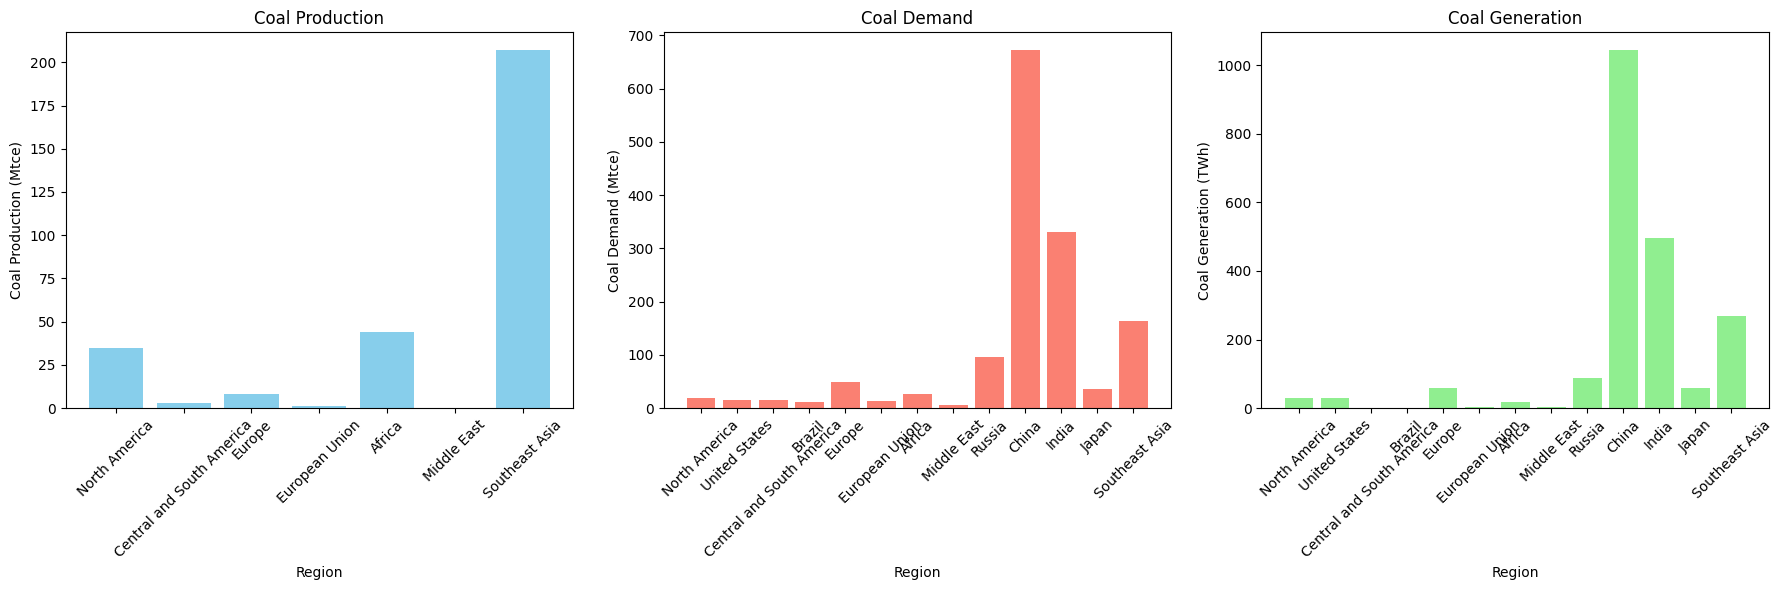

In [ ]:
import matplotlib.pyplot as plt

# Filter data for coal production, demand, and generation
coal_production = coal_combined[coal_combined['Flow_Encoded'] == 1]
coal_demand = coal_combined[coal_combined['Flow_Encoded'] == 2]
coal_generation = coal_combined[coal_combined['Flow_Encoded'] ==0]

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot coal production
axs[0].bar(coal_production['Region'], coal_production['Ann Year 2050'], color='skyblue')
axs[0].set_title('Coal Production')
axs[0].set_xlabel('Region')
axs[0].set_ylabel('Coal Production (Mtce)')
axs[0].tick_params(axis='x', rotation=45)

# Plot coal demand
axs[1].bar(coal_demand['Region'], coal_demand['Ann Year 2050'], color='salmon')
axs[1].set_title('Coal Demand')
axs[1].set_xlabel('Region')
axs[1].set_ylabel('Coal Demand (Mtce)')
axs[1].tick_params(axis='x', rotation=45)

# Plot coal generation
axs[2].bar(coal_generation['Region'], coal_generation['Ann Year 2050'], color='lightgreen')
axs[2].set_title('Coal Generation')
axs[2].set_xlabel('Region')
axs[2].set_ylabel('Coal Generation (TWh)')  #  the unit is TWh
axs[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Year 2022

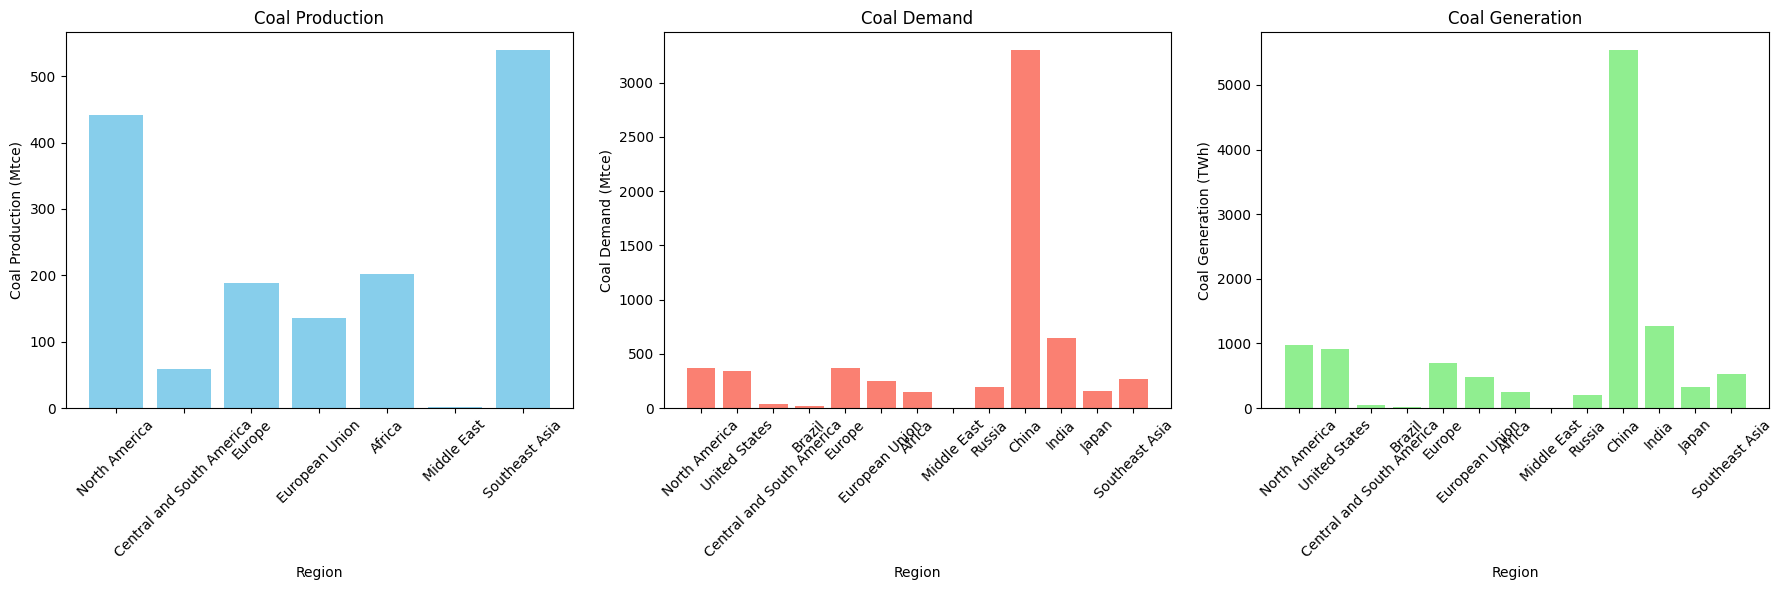

In [ ]:
import matplotlib.pyplot as plt

# Filter data for coal production, demand, and generation
coal_production = coal_combined[coal_combined['Flow_Encoded'] == 1]
coal_demand = coal_combined[coal_combined['Flow_Encoded'] == 2]
coal_generation = coal_combined[coal_combined['Flow_Encoded'] ==0]

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot coal production
axs[0].bar(coal_production['Region'], coal_production['Hist Year 2022'], color='skyblue')
axs[0].set_title('Coal Production')
axs[0].set_xlabel('Region')
axs[0].set_ylabel('Coal Production (Mtce)')
axs[0].tick_params(axis='x', rotation=45)

# Plot coal demand
axs[1].bar(coal_demand['Region'], coal_demand['Hist Year 2022'], color='salmon')
axs[1].set_title('Coal Demand')
axs[1].set_xlabel('Region')
axs[1].set_ylabel('Coal Demand (Mtce)')
axs[1].tick_params(axis='x', rotation=45)

# Plot coal generation
axs[2].bar(coal_generation['Region'], coal_generation['Hist Year 2022'], color='lightgreen')
axs[2].set_title('Coal Generation')
axs[2].set_xlabel('Region')
axs[2].set_ylabel('Coal Generation (TWh)')  # the unit is TWh
axs[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Now, we deal with the natural gasdata (demand, generation and production)

In [230]:
df1 = pd.read_csv('Natural gas demand (bcm)_table.csv')
df2 = pd.read_csv('Natural gas generation (TWh)_table.csv')
df3 =pd.read_csv('Natural gas production (bcm) _table.csv')

In [231]:
df1_cleaned, missing_data1 = clean_and_rename(df1)
df2_cleaned, missing_data2 = clean_and_rename(df2)
df3_cleaned, missing_data3 = clean_and_rename(df3)

In [232]:
df1_clustered = perform_clustering(df1_cleaned)
df2_clustered = perform_clustering(df2_cleaned)
df3_clustered = perform_clustering(df3_cleaned)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-179-69bf30b1d9d7>:35: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  kmeans.fit(df[['Region_Encoded']])


Flow - Total energy supply	- Encoded 2 (demand)

Flow - Electricity generation - Encoded 1  (generation)

Flow - Production -  Encoded 0 (production)

Unit - TWh -  Encoded 1

Unit - bcm-  Encoded 0

In [233]:
df1_clustered = df1_clustered.drop(columns= ['Category', "Product"])
df2_clustered = df2_clustered.drop(columns= ['Category', "Product"])
df3_clustered = df3_clustered.drop(columns= ['Category', "Product"])

In [234]:
# Concatenate the datasets vertically
gas_combined = pd.concat([df1_clustered, df2_clustered, df3_clustered], ignore_index=True)

# Set numerical encoders for 'Flow' and 'Unit'
label_encoder = LabelEncoder()
gas_combined['Flow_Encoded'] = label_encoder.fit_transform(gas_combined['Flow'])
gas_combined['Unit_Encoded'] = label_encoder.fit_transform(gas_combined['Unit'])

# Optionally, drop the original 'Flow' and 'Unit' columns
gas_combined = gas_combined.drop(['Flow','Unit'], axis=1)

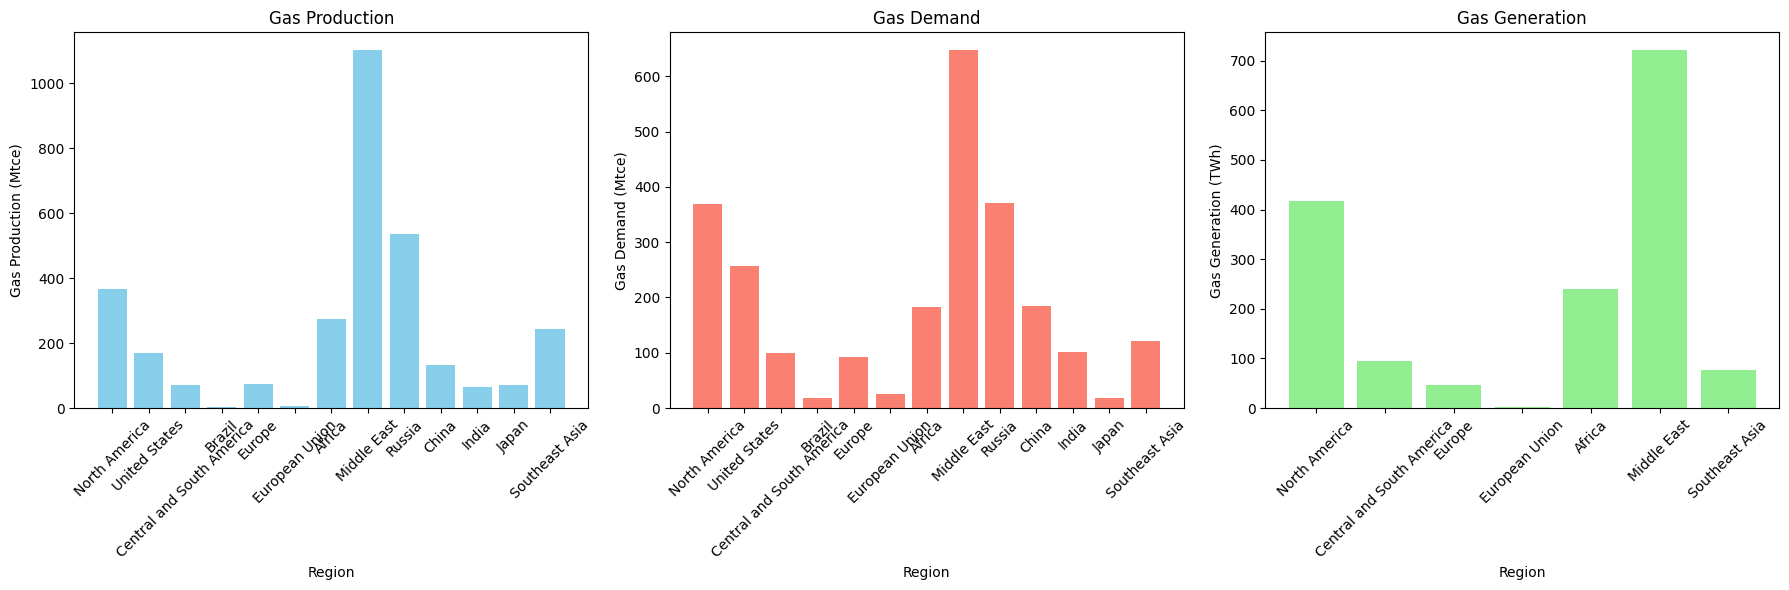

In [235]:
import matplotlib.pyplot as plt

# Filter data for coal production, demand, and generation
gas_production = coal_combined[coal_combined['Flow_Encoded'] == 0]
gas_demand = coal_combined[coal_combined['Flow_Encoded'] == 2]
gas_generation = coal_combined[coal_combined['Flow_Encoded'] ==1]

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot coal production
axs[0].bar(gas_production['Region'], gas_production['Ann Year 2050'], color='skyblue')
axs[0].set_title('Gas Production')
axs[0].set_xlabel('Region')
axs[0].set_ylabel('Gas Production (bcm)')
axs[0].tick_params(axis='x', rotation=45)

# Plot coal demand
axs[1].bar(gas_demand['Region'], gas_demand['Ann Year 2050'], color='salmon')
axs[1].set_title('Gas Demand')
axs[1].set_xlabel('Region')
axs[1].set_ylabel('Gas Demand (bcm)')
axs[1].tick_params(axis='x', rotation=45)

# Plot coal generation
axs[2].bar(gas_generation['Region'], gas_generation['Ann Year 2050'], color='lightgreen')
axs[2].set_title('Gas Generation')
axs[2].set_xlabel('Region')
axs[2].set_ylabel('Gas Generation (TWh)')  #  the unit is TWh
axs[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


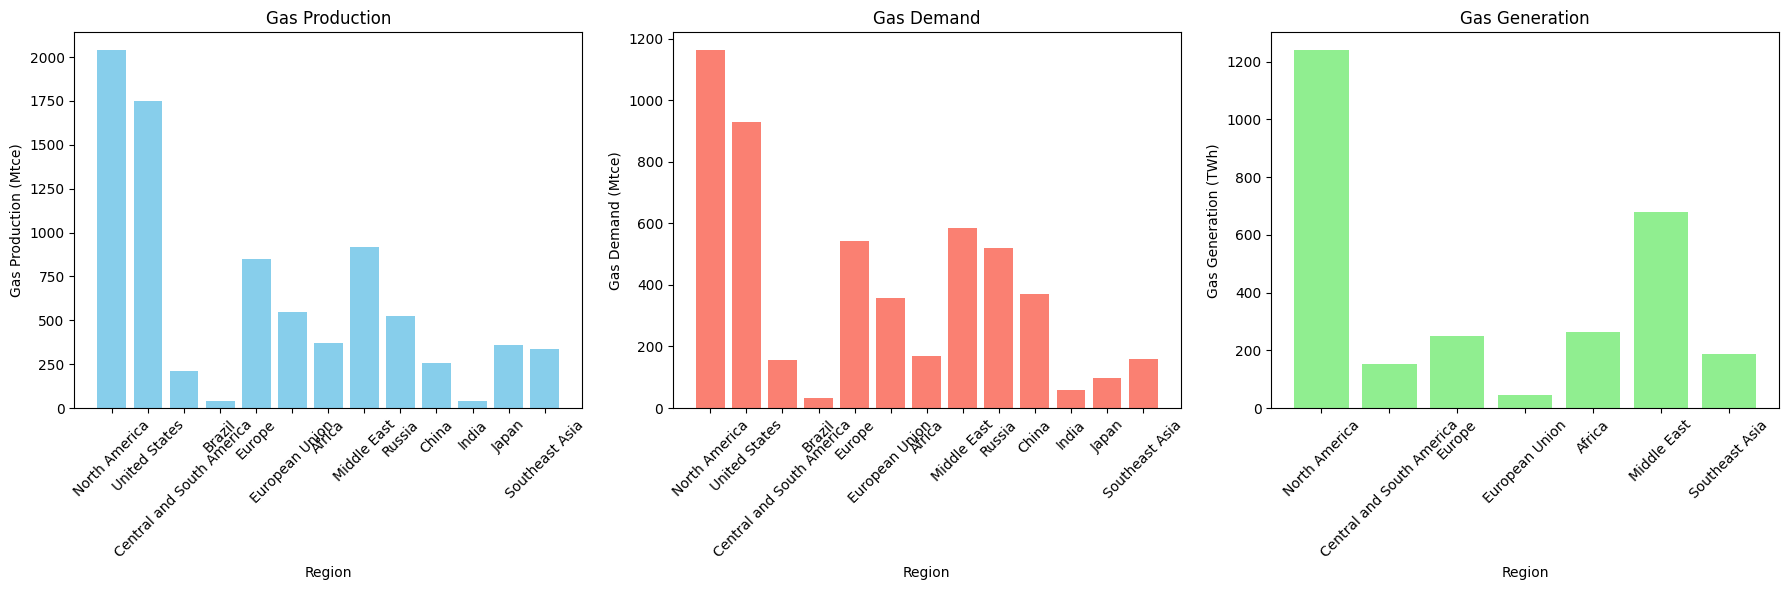

In [236]:
import matplotlib.pyplot as plt

# Filter data for coal production, demand, and generation
gas_production = coal_combined[coal_combined['Flow_Encoded'] == 0]
gas_demand = coal_combined[coal_combined['Flow_Encoded'] == 2]
gas_generation = coal_combined[coal_combined['Flow_Encoded'] ==1]

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot coal production
axs[0].bar(gas_production['Region'], gas_production['Hist Year 2022'], color='skyblue')
axs[0].set_title('Gas Production')
axs[0].set_xlabel('Region')
axs[0].set_ylabel('Gas Production (bcm)')
axs[0].tick_params(axis='x', rotation=45)

# Plot coal demand
axs[1].bar(gas_demand['Region'], gas_demand['Hist Year 2022'], color='salmon')
axs[1].set_title('Gas Demand')
axs[1].set_xlabel('Region')
axs[1].set_ylabel('Gas Demand (bcm)')
axs[1].tick_params(axis='x', rotation=45)

# Plot coal generation
axs[2].bar(gas_generation['Region'], gas_generation['Hist Year 2022'], color='lightgreen')
axs[2].set_title('Gas Generation')
axs[2].set_xlabel('Region')
axs[2].set_ylabel('Gas Generation (TWh)')  # the unit is TWh
axs[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Comparing Energy generation - Electricity, Nuclear, Renewables, Solar PV, Wind.

In [253]:
df1 =  pd.read_csv('Electricity generation (TWh)_table.csv')
df2 =  pd.read_csv('Nuclear generation (TWh)_table.csv')
df3 =   pd.read_csv('Renewables generation (TWh)_table.csv')
df4 = pd.read_csv('Solar PV generation (TWh)_table.csv')
df5 = pd.read_csv('Wind generation (TWh)_table.csv')

In [254]:
df1_cleaned, missing_data1 = clean_and_rename(df1)
df2_cleaned, missing_data2 = clean_and_rename(df2)
df3_cleaned, missing_data3 = clean_and_rename(df3)
df4_cleaned, missing_data4 = clean_and_rename(df4)
df5_cleaned, missing_data5 = clean_and_rename(df5)

In [255]:
df1_clustered = perform_clustering(df1_cleaned)
df2_clustered = perform_clustering(df2_cleaned)
df3_clustered = perform_clustering(df3_cleaned)
df4_clustered = perform_clustering(df4_cleaned)
df5_clustered = perform_clustering(df5_cleaned)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [263]:
df5_clustered.head()

,Category,Product,Flow,Unit,Region,Hist Year 2010,Hist Year 2021,Hist Year 2022,Stat Year 2030,Stat Year 2050,Ann Year 2030,Ann Year 2050,Region_Grouped,Region_Encoded,Cluster_Labels
2,Energy,Wind,Electricity generation,TWh,North America,105.11,438.46,500.04,1107.19,2209.40,1421.07,3998.18,North America,6,3
3,Energy,Wind,Electricity generation,TWh,United States,95.15,382.81,442.39,1001.43,1916.84,1248.88,3516.43,North America,6,3
4,Energy,Wind,Electricity generation,TWh,Central and South America,3.46,105.84,119.13,251.83,655.67,279.02,1104.97,Central and South America,2,4
5,Energy,Wind,Electricity generation,TWh,Brazil,2.18,72.29,81.63,158.14,405.68,165.03,466.18,Central and South America,2,4
6,Energy,Wind,Electricity generation,TWh,Europe,154.02,500.16,556.53,1304.29,2382.26,1518.01,3489.02,Europe,4,2


In [264]:
df1_clustered = df1_clustered.drop(columns= ['Category', "Unit"])
df2_clustered = df2_clustered.drop(columns= ['Category', "Unit"])
df3_clustered = df3_clustered.drop(columns= ['Category', "Unit"])
df4_clustered = df4_clustered.drop(columns= ['Category', "Unit"])
df5_clustered = df5_clustered.drop(columns= ['Category', "Unit"])



In [268]:
# Concatenate the datasets vertically
gas_combined = pd.concat([df1_clustered, df2_clustered, df3_clustered,df4_clustered,df5_clustered], ignore_index=True)

# Set numerical encoders for 'Product'
label_encoder = LabelEncoder()
gas_combined['Product_Encoded'] = label_encoder.fit_transform(gas_combined['Product'])

# Optionally, drop the original 'Flow' and 'Product' columns
gas_combined = gas_combined.drop(['Flow','Product'], axis=1)

Product - Electricity generation(total) - Encoded - 3

Product - Nuclear - Encoded - 0

Product - Renewables - Encoded - 1

Product - Solar PV	- Encoded -2

Product - Wind - Encoded 4

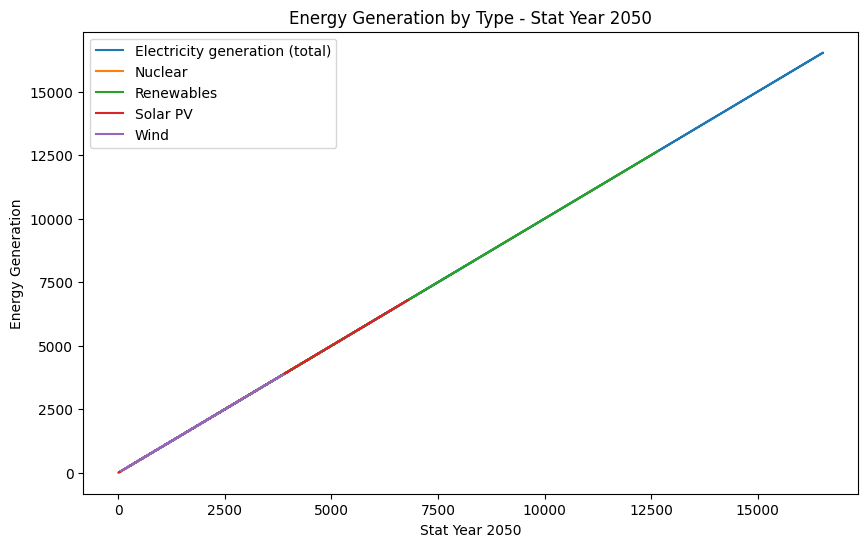

In [271]:
import matplotlib.pyplot as plt

# Filter data for different types of energy generation
electricity_generation = gas_combined[gas_combined['Product_Encoded'] == 3]  # Assuming '3' corresponds to 'Electricity generation (total)'
nuclear_generation = gas_combined[gas_combined['Product_Encoded'] == 0]  # Assuming '0' corresponds to 'Nuclear'
renewables_generation = gas_combined[gas_combined['Product_Encoded'] == 1]  # Assuming '1' corresponds to 'Renewables'
solar_pv_generation = gas_combined[gas_combined['Product_Encoded'] == 2]  # Assuming '2' corresponds to 'Solar PV'
wind_generation = gas_combined[gas_combined['Product_Encoded'] == 4]  # Assuming '4' corresponds to 'Wind'

# Create a figure
plt.figure(figsize=(10, 6))

# Plot curves for different types of energy generation
plt.plot(electricity_generation['Stat Year 2050'], electricity_generation['Stat Year 2050'], label='Electricity generation (total)')
plt.plot(nuclear_generation['Stat Year 2050'], nuclear_generation['Stat Year 2050'], label='Nuclear')
plt.plot(renewables_generation['Stat Year 2050'], renewables_generation['Stat Year 2050'], label='Renewables')
plt.plot(solar_pv_generation['Stat Year 2050'], solar_pv_generation['Stat Year 2050'], label='Solar PV')
plt.plot(wind_generation['Stat Year 2050'], wind_generation['Stat Year 2050'], label='Wind')

# Add labels and title
plt.xlabel('Stat Year 2050')
plt.ylabel('Energy Generation')
plt.title('Energy Generation by Type - Stat Year 2050')

# Add legend
plt.legend()

# Show the plot
plt.show()


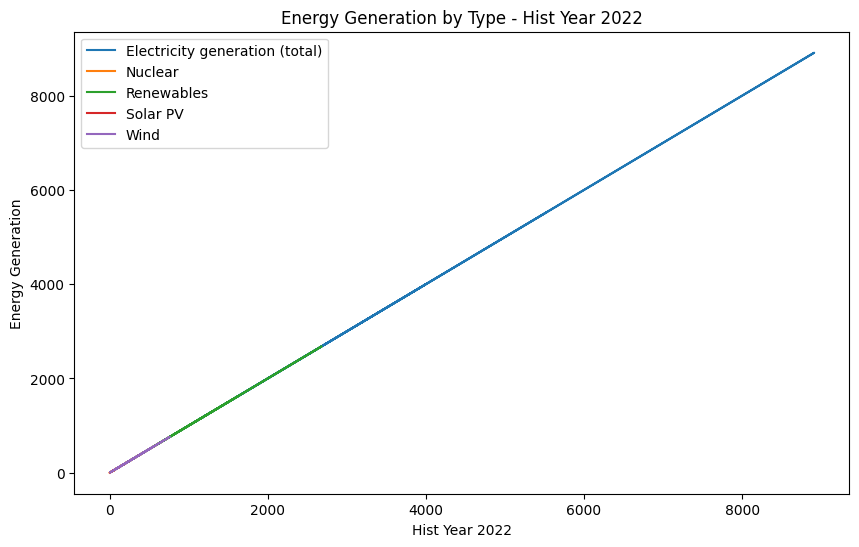

In [273]:
# Create a figure
plt.figure(figsize=(10, 6))

# Plot curves for different types of energy generation
plt.plot(electricity_generation['Hist Year 2022'], electricity_generation['Hist Year 2022'], label='Electricity generation (total)')
plt.plot(nuclear_generation['Hist Year 2022'], nuclear_generation['Hist Year 2022'], label='Nuclear')
plt.plot(renewables_generation['Hist Year 2022'], renewables_generation['Hist Year 2022'], label='Renewables')
plt.plot(solar_pv_generation['Hist Year 2022'], solar_pv_generation['Hist Year 2022'], label='Solar PV')
plt.plot(wind_generation['Hist Year 2022'], wind_generation['Hist Year 2022'], label='Wind')

# Add labels and title
plt.xlabel('Hist Year 2022')
plt.ylabel('Energy Generation')
plt.title('Energy Generation by Type - Hist Year 2022')

# Add legend
plt.legend()

# Show the plot
plt.show()

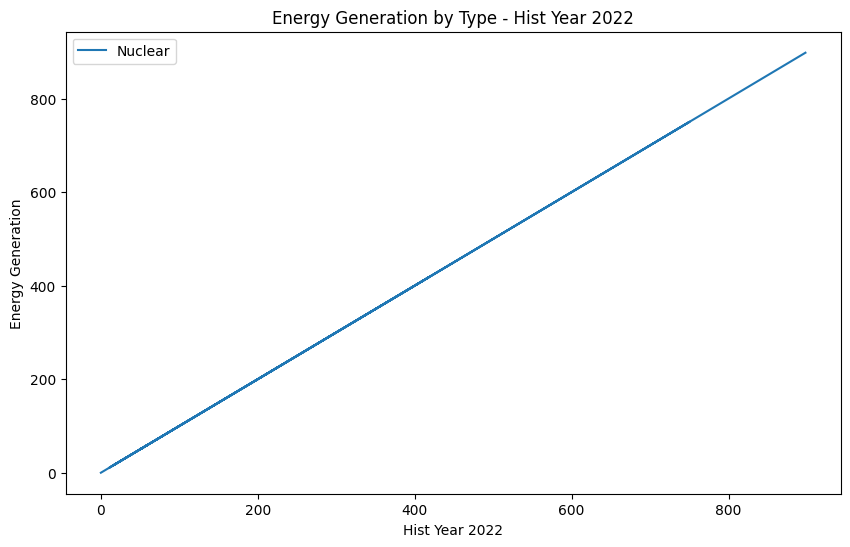

In [275]:
# Create a figure
plt.figure(figsize=(10, 6))

# Plot curves for different types of energy generation
plt.plot(nuclear_generation['Hist Year 2022'], nuclear_generation['Hist Year 2022'], label='Nuclear')

# Add labels and title
plt.xlabel('Hist Year 2022')
plt.ylabel('Energy Generation')
plt.title('Energy Generation by Type - Hist Year 2022')

# Add legend
plt.legend()

# Show the plot
plt.show()

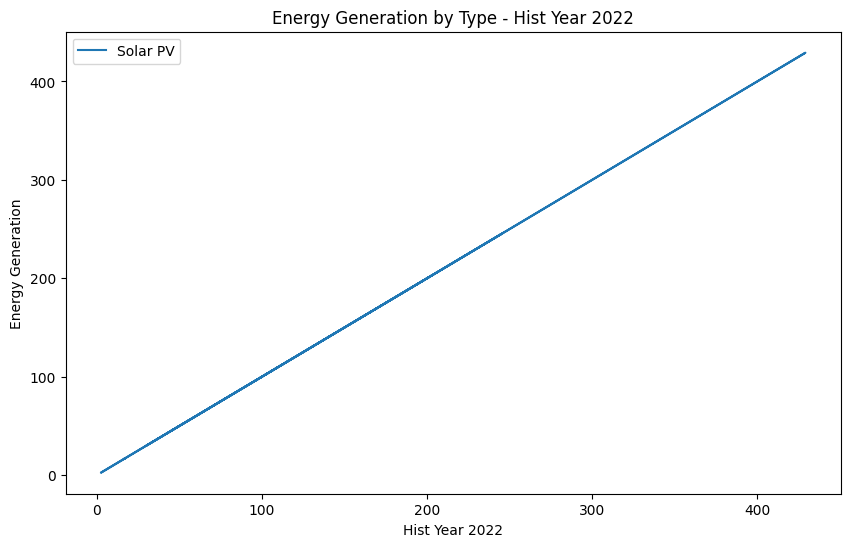

In [274]:
# Create a figure
plt.figure(figsize=(10, 6))

# Plot curves for different types of energy generation
plt.plot(solar_pv_generation['Hist Year 2022'], solar_pv_generation['Hist Year 2022'], label='Solar PV')

# Add labels and title
plt.xlabel('Hist Year 2022')
plt.ylabel('Energy Generation')
plt.title('Energy Generation by Type - Hist Year 2022')

# Add legend
plt.legend()

# Show the plot
plt.show()